In [1]:
using Distributions
using StatsPlots
using StatsFuns: logit, logistic
using Roots
using StatsBase: ecdf
using Memoization
using SpecialFunctions

x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)

In [2]:
"""
事前分布 Beta(a, b) のもとでn回中ｋ回成功の場合の事後分布は Beta(k+a, n-k+b) になる。
デフォルトでは a = b = 1 の一様事前分布を採用することにする。
"""
posterior_dist(n, k; a=1, b=a) = Beta(k + a, n - k + b)

"""
pvalue_bayes(n, p, k; a, b) < α ⇔ p ∉ (ベイズ版100(1-α)%信用区間)
"""
@memoize function pvalue_bayes(n, p, k; a = 1, b = a)
    posterior = posterior_dist(n, k; a, b)
    v0 = logpdf(posterior, p)
    f(t) = logpdf(posterior, logistic(t)) - v0
    m = params(posterior) |> ((α, β),) -> (α - 1)/(α + β - 2)
    if m ≤ 0
        s = ccdf(posterior, p)
    elseif m ≥ 1
        s = cdf(posterior, p)
    elseif p ≤ m
        q = logistic(find_zero(f, min(50, logit(m) + 1)))
        s = cdf(posterior, p) + ccdf(posterior, q)
    else
        q = logistic(find_zero(f, max(-50, logit(m) - 1)))
        s = cdf(posterior, q) + ccdf(posterior, p)
    end
    min(1, s)
end

"""
Bernoulli(p)分布の独立試行をNまで行うとき、
pがベイズ版信用区間から外れるまでの試行回数をL個計算
"""
function bayeshacking(N, p; α = 0.05, L = 10^4, a = 1, b = a)
    numtrials = fill(N + 1, L)
    Threads.@threads for i in 1:L
        k = 0
        for n in 1:N
            k += rand(Bernoulli(p))
            if pvalue_bayes(n, p, k; a, b) < α
                numtrials[i] = n
                break
            end
        end
    end
    numtrials
end

bayeshacking

In [3]:
numtrials_bhack = bayeshacking(10^3, 0.5)
[(n, ecdf(numtrials_bhack)(n)) for n in (10, 100, 1000)]

3-element Vector{Tuple{Int64, Float64}}:
 (10, 0.2221)
 (100, 0.4095)
 (1000, 0.5559)

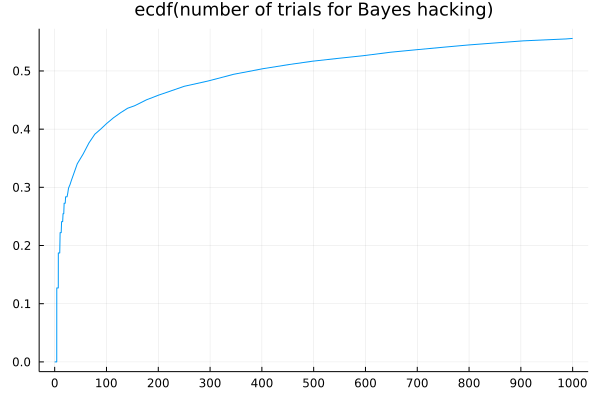

In [4]:
plot(n -> ecdf(numtrials_bhack)(n), 0, 10^3; label="", xtick=0:100:1000)
title!("ecdf(number of trials for Bayes hacking)"; titlefontsize=12)

In [5]:
"""通常のP値函数(exact版)"""
@memoize function pvalue_exact(n, p, k)
    bin = Binomial(n, p)
    p0 = pdf(bin, k)
    s = sum(pdf(bin, j) for j in support(bin) if pdf(bin, j) ⪅ p0)
    min(1, s)
end

"""通常のP値函数(正規分布近似)"""
@memoize function pvalue_normal(n, p, k)
    bin = Binomial(n, p)
    normal = Normal(mean(bin), std(bin))
    min(1, 2cdf(normal, k), 2ccdf(normal, k))
end

"""
Bernoulli(p)分布の独立試行をNまで行うとき、
P値がα未満になるまでの試行回数をL個計算
"""
function phacking(pvalue_func, N, p; α = 0.05, L = 10^4)
    numtrials = fill(N + 1, L)
    Threads.@threads for i in 1:L
        k = 0
        for n in 1:N
            k += rand(Bernoulli(p))
            if pvalue_func(n, p, k) < α
                numtrials[i] = n
                break
            end
        end
    end
    numtrials
end

phacking

In [6]:
numtrials_phack_exact = phacking(pvalue_exact, 10^3, 0.5)
[(n, ecdf(numtrials_phack_exact)(n)) for n in (10, 100, 1000)]

3-element Vector{Tuple{Int64, Float64}}:
 (10, 0.0536)
 (100, 0.2219)
 (1000, 0.402)

In [7]:
numtrials_phack_normal = phacking(pvalue_normal, 10^3, 0.5)
[(n, ecdf(numtrials_phack_normal)(n)) for n in (10, 100, 1000)]

3-element Vector{Tuple{Int64, Float64}}:
 (10, 0.1586)
 (100, 0.3737)
 (1000, 0.5314)

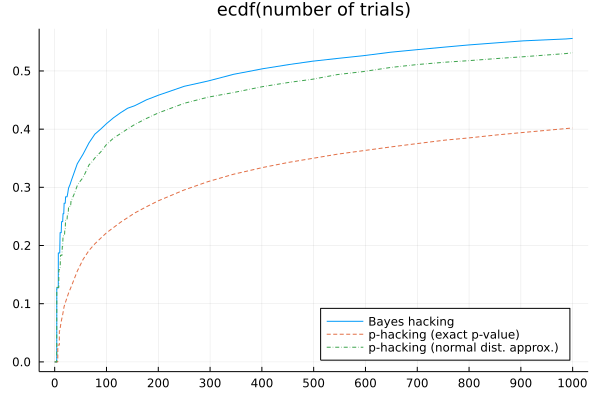

In [8]:
plot(; legend=:bottomright)
plot!(n -> ecdf(numtrials_bhack)(n), 0, 10^3; label="Bayes hacking", xtick=0:100:1000)
plot!(n -> ecdf(numtrials_phack_exact)(n), 0, 10^3; label="p-hacking (exact p-value)", xtick=0:100:1000, ls=:dash)
plot!(n -> ecdf(numtrials_phack_normal)(n), 0, 10^3; label="p-hacking (normal dist. approx.)", xtick=0:100:1000, ls=:dashdot)
title!("ecdf(number of trials)"; titlefontsize=12)

In [9]:
"""
対数周辺尤度比 (χ²分布のスケールに合わせるために2倍しておく)
Bayes因子 = exp(logmarginallikrat(n, p, k; a, b)/2)
"""
@memoize function logmarginallikrat(n, p, k; a=1, b=a)
    logmarginallik = 2(logbeta(k + a, n - k + b) - logbeta(a, b))
    logmarginallik0 = 2(k*log(p) + (n - k)*log(1 - p))
    logmarginallik - logmarginallik0
end

"""
Bayes因子ハッキングに挑戦
Bayes因子 > threshold となるまでデータを取得し続ける。
"""
function try_bfhacking(N, p; threshold=10, L=10^4, a=1, b=a)
    numtrials = fill(N + 1, L)
    Threads.@threads for i in 1:L
        k = 0
        for n in 1:N
            k += rand(Bernoulli(p))
            if logmarginallikrat(n, p, k; a, b) > 2log(threshold)
                numtrials[i] = n
                break
            end
        end
    end
    numtrials
end

"""
Bayes因子ハッキングに類似のpハッキングに挑戦
"""
function try_phacking_like_bfhacking(pvalue_func, N, p; threshold=10, L=10^4)
    numtrials = fill(N + 1, L)
    Threads.@threads for i in 1:L
        k = 0
        for n in 1:N
            k += rand(Bernoulli(p))
            α_n = ccdf(Chisq(1), 2log(threshold) + log(n))
            if pvalue_func(n, p, k) < α_n
                numtrials[i] = n
                break
            end
        end
    end
    numtrials
end

try_phacking_like_bfhacking

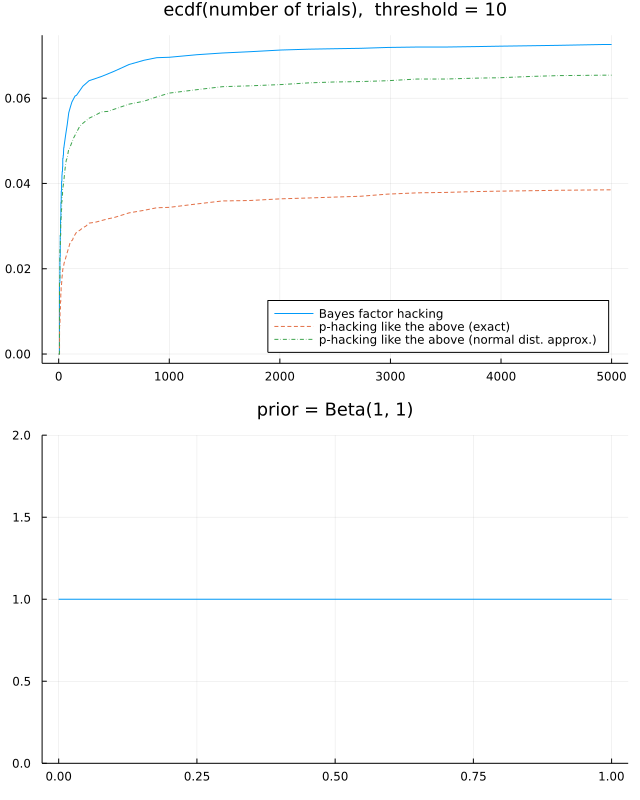

In [10]:
N, threshold = 5000, 10
a, b = 1, 1
numtrials_lmlrhack = try_bfhacking(N, 0.5; threshold, a, b)
numtrials_phack_like_lmlrhack_exact = try_phacking_like_bfhacking(pvalue_exact, N, 0.5; threshold)
numtrials_phack_like_lmlrhack_normal = try_phacking_like_bfhacking(pvalue_normal, N, 0.5; threshold)

P = plot(; legend=:bottomright)
plot!(n -> ecdf(numtrials_lmlrhack)(n), 0, N; label="Bayes factor hacking")
plot!(n -> ecdf(numtrials_phack_like_lmlrhack_exact)(n), 0, N; label="p-hacking like the above (exact)", ls=:dash)
plot!(n -> ecdf(numtrials_phack_like_lmlrhack_normal)(n), 0, N; label="p-hacking like the above (normal dist. approx.)", ls=:dashdot)
title!("ecdf(number of trials),  threshold = $threshold"; titlefontsize=12)

Q = plot(Beta(a, b); ylim=(0, 2), label="")
title!("prior = Beta($a, $a)"; titlefontsize=12)

plot(P, Q; size=(640, 800), layout=(2, 1))

この場合には threshold = 5 のとき、Bayes因子 > 10 という条件でデータ取得を止めることに成功する確率は数パーセントのオーダーになっている。これの類似をP値を使ってやっても概ね結果は同じになる(有意水準を `α_n = ccdf(Chisq(1), 2log(threshold) + log(n))` によって n について単調減少するように決めている)。

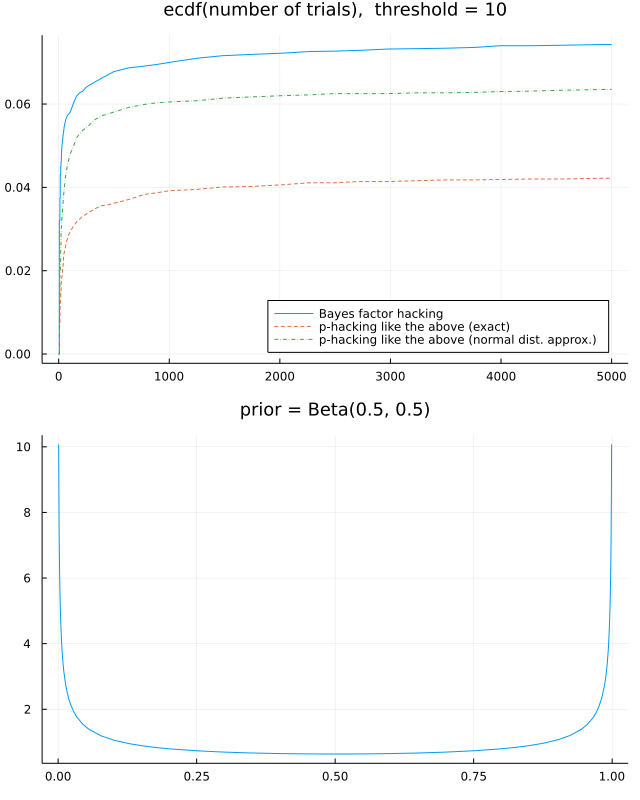

In [11]:
N, threshold = 5000, 10
a, b = 0.5, 0.5
numtrials_lmlrhack = try_bfhacking(N, 0.5; threshold, a, b)
numtrials_phack_like_lmlrhack_exact = try_phacking_like_bfhacking(pvalue_exact, N, 0.5; threshold)
numtrials_phack_like_lmlrhack_normal = try_phacking_like_bfhacking(pvalue_normal, N, 0.5; threshold)

P = plot(; legend=:bottomright)
plot!(n -> ecdf(numtrials_lmlrhack)(n), 0, N; label="Bayes factor hacking")
plot!(n -> ecdf(numtrials_phack_like_lmlrhack_exact)(n), 0, N; label="p-hacking like the above (exact)", ls=:dash)
plot!(n -> ecdf(numtrials_phack_like_lmlrhack_normal)(n), 0, N; label="p-hacking like the above (normal dist. approx.)", ls=:dashdot)
title!("ecdf(number of trials),  threshold = $threshold"; titlefontsize=12)

Q = plot(Beta(a, b), 0.001, 0.999; label="")
title!("prior = Beta($a, $a)"; titlefontsize=12)

plot(P, Q; size=(640, 800), layout=(2, 1))

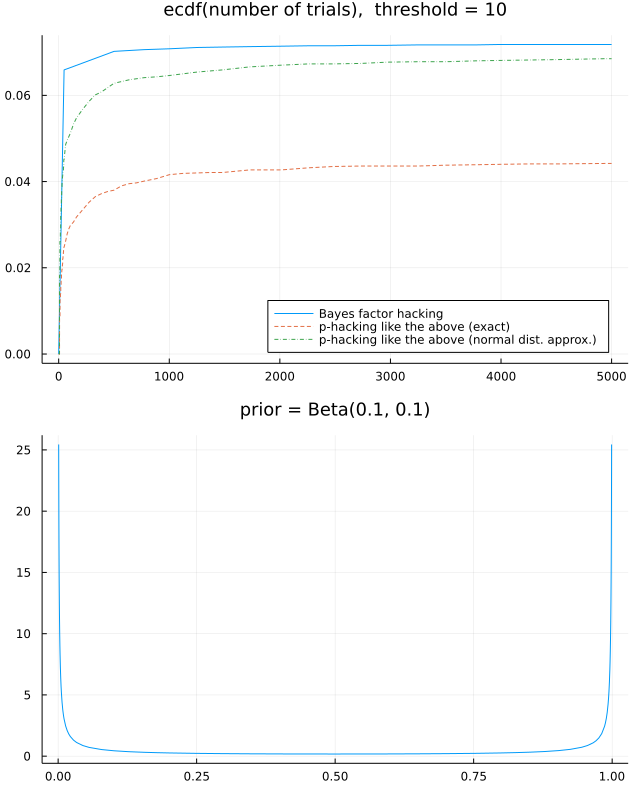

In [12]:
N, threshold = 5000, 10
a, b = 0.1, 0.1
numtrials_lmlrhack = try_bfhacking(N, 0.5; threshold, a, b)
numtrials_phack_like_lmlrhack_exact = try_phacking_like_bfhacking(pvalue_exact, N, 0.5; threshold)
numtrials_phack_like_lmlrhack_normal = try_phacking_like_bfhacking(pvalue_normal, N, 0.5; threshold)

P = plot(; legend=:bottomright)
plot!(n -> ecdf(numtrials_lmlrhack)(n), 0, N; label="Bayes factor hacking")
plot!(n -> ecdf(numtrials_phack_like_lmlrhack_exact)(n), 0, N; label="p-hacking like the above (exact)", ls=:dash)
plot!(n -> ecdf(numtrials_phack_like_lmlrhack_normal)(n), 0, N; label="p-hacking like the above (normal dist. approx.)", ls=:dashdot)
title!("ecdf(number of trials),  threshold = $threshold"; titlefontsize=12)

Q = plot(Beta(a, b), 0.001, 0.999; label="")
title!("prior = Beta($a, $a)"; titlefontsize=12)

plot(P, Q; size=(640, 800), layout=(2, 1))

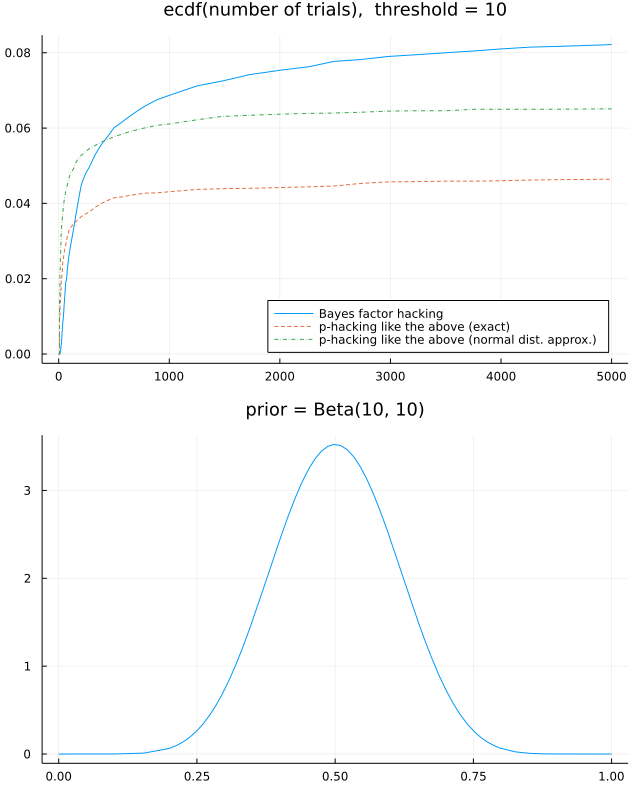

In [13]:
N, threshold = 5000, 10
a, b = 10, 10
numtrials_lmlrhack = try_bfhacking(N, 0.5; threshold, a, b)
numtrials_phack_like_lmlrhack_exact = try_phacking_like_bfhacking(pvalue_exact, N, 0.5; threshold)
numtrials_phack_like_lmlrhack_normal = try_phacking_like_bfhacking(pvalue_normal, N, 0.5; threshold)

P = plot(; legend=:bottomright)
plot!(n -> ecdf(numtrials_lmlrhack)(n), 0, N; label="Bayes factor hacking")
plot!(n -> ecdf(numtrials_phack_like_lmlrhack_exact)(n), 0, N; label="p-hacking like the above (exact)", ls=:dash)
plot!(n -> ecdf(numtrials_phack_like_lmlrhack_normal)(n), 0, N; label="p-hacking like the above (normal dist. approx.)", ls=:dashdot)
title!("ecdf(number of trials),  threshold = $threshold"; titlefontsize=12)

Q = plot(Beta(a, b); label="")
title!("prior = Beta($a, $a)"; titlefontsize=12)

plot(P, Q; size=(640, 800), layout=(2, 1))